In [1]:
using AutomotiveDrivingModels
using AutoScenes
using AutoViz
using NGSIM

In [3]:
trajdata = load_trajdata(1);

In [4]:
scene = Scene()
for frame in 1 : nframes(trajdata)
    get!(scene, trajdata, frame)
    for (i, veh) in enumerate(scene)
        @assert AutoScenes.posF_matches_posG(veh.state, trajdata.roadway)
    end
end

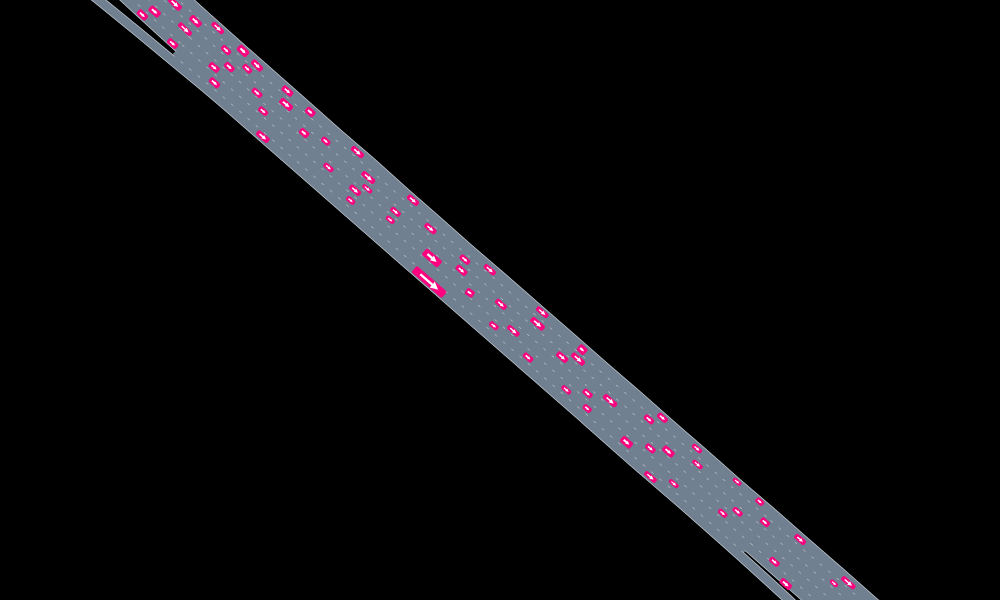

In [5]:
scene = get!(Scene(), trajdata, 4000)
render(scene, trajdata.roadway)

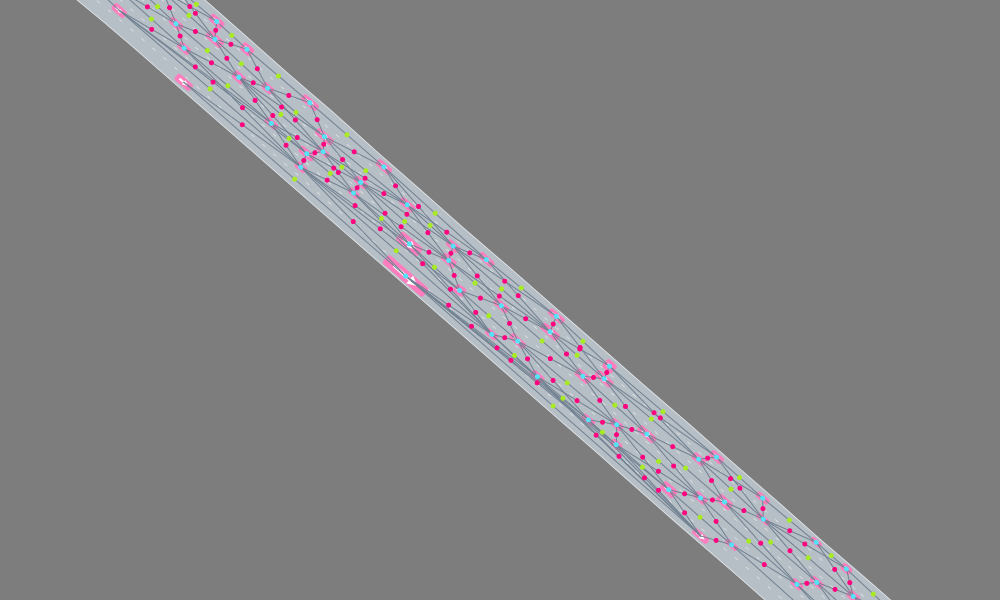

In [6]:
structure = gen_scene_structure(scene, trajdata.roadway, create_shared_factors())
overlays = SceneOverlay[Overwash(RGBA(1.0,1.0,1.0,0.7)), SceneStructureOverlay(structure)]
render(scene, trajdata.roadway, overlays, cam=SceneFollowCamera(4.0))

In [7]:
# for NGSIM
const REGIONS = Dict{ASCIIString, SubSceneExtractParams}(
  "101A" => SubSceneExtractParams(VecSE2(1966406.608, 570903.793, 2.382), 100.0, 27.0),  
  "101B" => SubSceneExtractParams(VecSE2(1966501.608, 570804.793, 2.425), 100.0, 25.0),
  "101C" => SubSceneExtractParams(VecSE2(1966406.608, 570903.793, 2.382), 100.0, 25.0),
  "80A"  => SubSceneExtractParams(VecSE2(6042777.824, 2133302.509, 1.684)),
  "80B"  => SubSceneExtractParams(VecSE2(6042697.824, 2134372.509, 1.745)),
  )

Dict{ASCIIString,AutoScenes.SubSceneExtractParams} with 5 entries:
  "80A"  => AutoScenes.SubSceneExtractParams(VecSE2({6042777.824, 2133302.509},…
  "101B" => AutoScenes.SubSceneExtractParams(VecSE2({1966501.608, 570804.793}, …
  "101A" => AutoScenes.SubSceneExtractParams(VecSE2({1966406.608, 570903.793}, …
  "80B"  => AutoScenes.SubSceneExtractParams(VecSE2({6042697.824, 2134372.509},…
  "101C" => AutoScenes.SubSceneExtractParams(VecSE2({1966406.608, 570903.793}, …

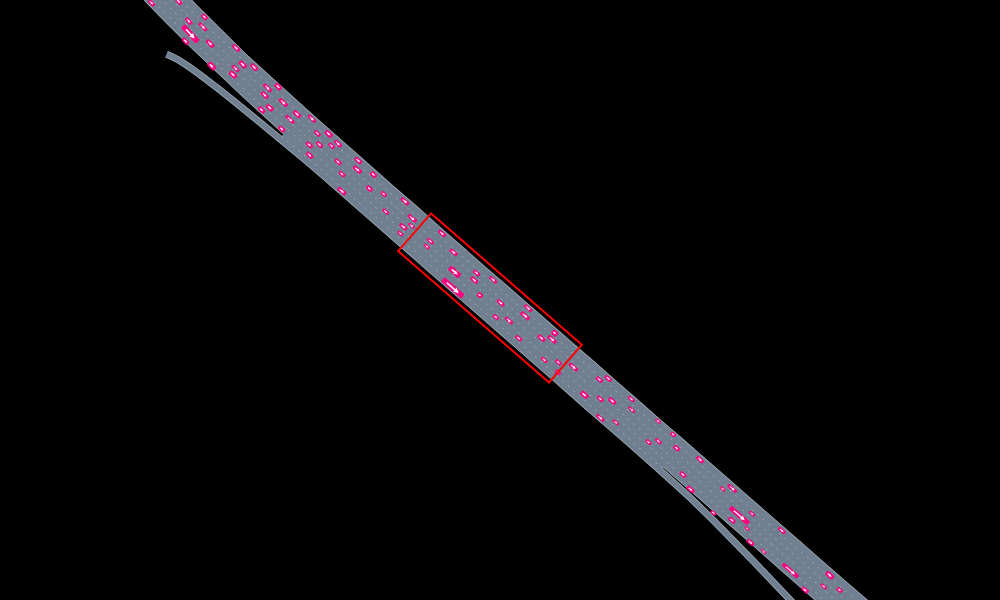

In [8]:
overlays = SceneOverlay[SubSceneExtractParamsOverlay(REGIONS["101B"])]
render(scene, trajdata.roadway, overlays, cam=SceneFollowCamera(2.0))

Interact.Slider{Float64}(Signal{Float64}(50.0, nactions=0),"width",50.0,linspace(25.0,75.0,101),true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"deltaX",0.0,linspace(-50.0,50.0,101),true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"deltaY",0.0,linspace(-50.0,50.0,101),true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"deltaP",0.0,linspace(-50.0,50.0,201),true)

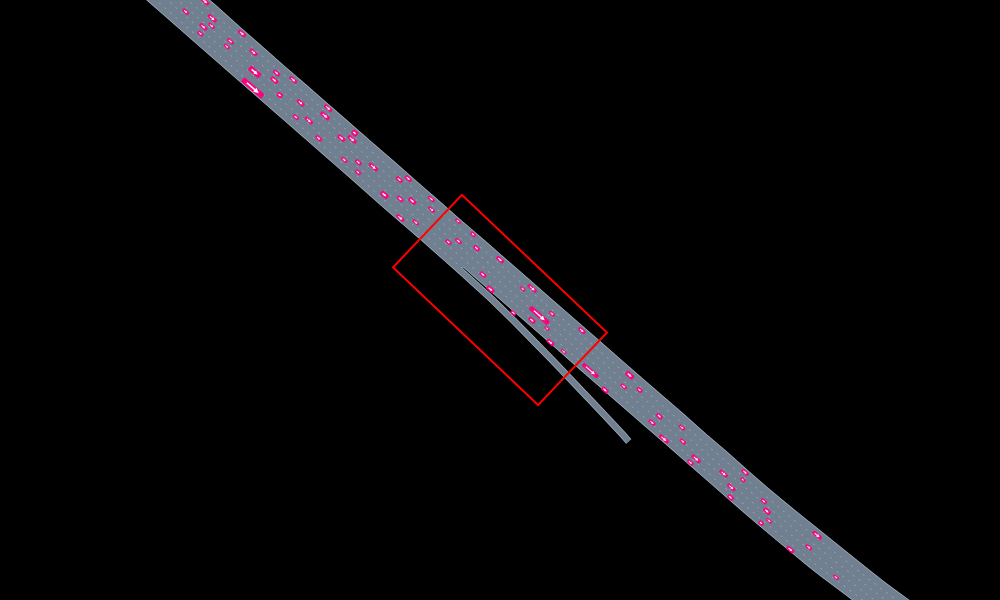

In [9]:
using Interact

region = SubSceneExtractParams(VecSE2(1966406.608,  570903.793, 2.382))
@manipulate for width in linspace(25.0,75.0,101),
                deltaX in linspace(-50.0, 50.0,101),
                deltaY in linspace(-50.0, 50.0,101),
                deltaP in linspace(-50.0, 50.0, 201)
    region = SubSceneExtractParams(VecSE2(1966606.608+deltaX,  570703.793+deltaY, 2.382+deg2rad(deltaP)), 100.0, width)
    overlays = SceneOverlay[SubSceneExtractParamsOverlay(region)]
    render(scene, trajdata.roadway, overlays, cam=StaticCamera(convert(VecE2, region.center), 2.0))
end

In [10]:
region.center

VecSE2({1966406.608, 570903.793}, 2.382)

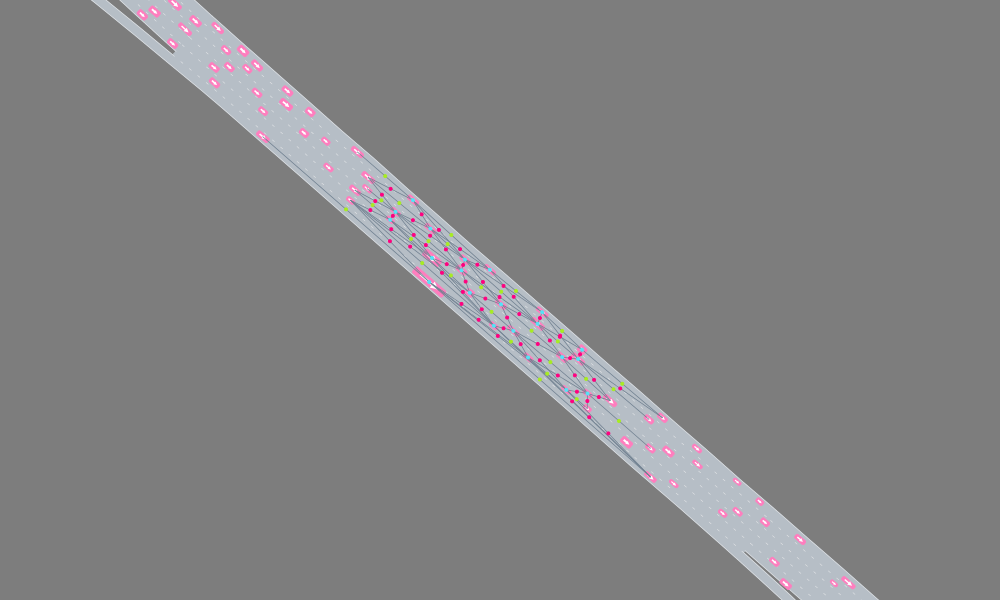

In [11]:
vehicle_indeces = pull_subscene(scene, REGIONS["101B"])
structure = gen_scene_structure(scene, trajdata.roadway, create_shared_factors(), vehicle_indeces)
overlays = SceneOverlay[Overwash(RGBA(1.0,1.0,1.0,0.7)), SceneStructureOverlay(structure)]
render(scene, trajdata.roadway, overlays, cam=SceneFollowCamera(3.0))

In [12]:
dset = pull_scene_dataset(trajdata, REGIONS["101B"])
length(dset)

736

In [12]:
calc_pseudolikelihood(dset)

-187.42036476292174

In [13]:
calc_pseudolikelihood_gradient(1, 1, dset, 10, 10, 0.001)

-0.7382499699925041

In [14]:
params = StochasticGradientAscentParams(batch_size=1, niter=1, 
                                        n_samples_monte_carlo_integration=1000,
                                        n_samples_monte_carlo_pseudolikelihood=1000)
tic()
stochastic_gradient_ascent!(dset, params)
toc()

for ϕ in dset.factors
    println(ϕ.template.form, "  ", ϕ.weights)
end

LoadError: LoadError: Could not find segid -1 in roadway
while loading In[14], in expression starting on line 5

In [17]:
calc_pseudolikelihood(dset)

-201.1536423137834

- verify that gradient descent converges
- verify that learned marginal distribution matches
- implement sampling
- compute metrics on sampled dataset
- train new model on full scenes
- compute metrics from vehicles for aux lane and main freeway

# Learned Marginal Distribution

In [15]:
using PGFPlots

g = GroupPlot(1, 3, groupStyle = "vertical sep = 1cm")
push!(g, Plots.Linear(collect(1:10), randn(10)))
push!(g, Plots.Linear(collect(1:10), randn(10)))
push!(g, Plots.Linear(collect(1:10), randn(10)))
g

! LaTeX Error: File `luatex85.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
   
l.2 \documentclass
                [tikz]{standalone}
End of file on the terminal!



Here is how much of LuaTeX's memory you used:
 11 strings out of 494693
 100000,89155 words of node,token memory allocated 188 words of node memory still in use:
   31 glue_spec, 1 dir nodes
   avail lists: 2:12,3:1
 3851 multiletter control sequences out of 65536+600000
 14 fonts using 562767 bytes
 10i,0n,7p,45b,8s stack positions out of 5000i,500n,10000p,200000b,100000s
!  ==> Fatal error occurred, no output PDF file produced!

Error saving as SVG


ErrorException: LaTeX error

In [16]:
using PGFPlots

function _cycle_linear_plot!(xarr::Vector{Float64}, yarr::Vector{Float64})
    append!(yarr, [0.0, 0.0, yarr[1]])
    append!(xarr, [xarr[end], xarr[1], xarr[1]])
    nothing
end
function plot_marginal_roadfactor(ϕ_road::SharedFactor;
    nbins_v::Int = 101,
    nbins_t::Int = 101,
    nbins_ϕ::Int = 101,
    )

    pts_v = collect(linspace(AutoScenes.BOUNDS_V[1], AutoScenes.BOUNDS_V[2], nbins_v))
    pts_t = collect(linspace(-3.0, 3.0, nbins_t))
    pts_ϕ = collect(linspace(AutoScenes.BOUNDS_ϕ[1], AutoScenes.BOUNDS_ϕ[2], nbins_ϕ))
    v_values = zeros(Float64, nbins_v)
    t_values = zeros(Float64, nbins_t)
    ϕ_values = zeros(Float64, nbins_ϕ)
    tot = 0.0

    for (j,t) in enumerate(pts_t)
        AutoScenes._set_and_standardize!(ϕ_road.template, t, 1)
        for (i,v) in enumerate(pts_v)
            AutoScenes._set_and_standardize!(ϕ_road.template, v, 2)
            for (k,ϕ) in enumerate(pts_ϕ)
                AutoScenes._set_and_standardize!(ϕ_road.template, ϕ, 3)
                
                e = evaluate_dot(ϕ_road)
                v_values[i] += e
                t_values[j] += e
                ϕ_values[k] += e
                tot += e
            end
        end
    end

    # produce a probability density
    v_values ./= tot
    t_values ./= tot
    ϕ_values ./= tot

    plot_width = "20cm"
    plot_height = "4cm"
    style = "solid, thick, mark=none, black"

    _cycle_linear_plot!(pts_v, v_values)
    _cycle_linear_plot!(pts_t, t_values)
    _cycle_linear_plot!(pts_ϕ, ϕ_values)

    g = GroupPlot(1, 3, groupStyle = "vertical sep = 1cm")
    push!(g, Axis(PGFPlots.Plots.Linear(pts_v, v_values, style=style*", fill=monokai3"), xlabel="speed [ft/s]", ylabel="pdf", width=plot_width, height=plot_height, enlargelimits="false"))
    push!(g, Axis(PGFPlots.Plots.Linear(pts_t, t_values, style=style*", fill=monokai4"), xlabel="lane centerline offset [ft]", ylabel="pdf", width=plot_width, height=plot_height, enlargelimits="false"))
    push!(g, Axis(PGFPlots.Plots.Linear(rad2deg(pts_ϕ), ϕ_values, style=style*", fill=monokai5"), xlabel="lane-relative heading [deg]", ylabel="pdf", width=plot_width, height=plot_height, enlargelimits="false"))
    g
end

plot_marginal_roadfactor(dset.factors[1])

[0.009587413726315342,0.009583849385465516,0.009580583101230939,0.00957761487361168,0.00957494470260762,0.00957257258821884,0.009570498530445237,0.009568722529287057,0.009567244584744047,0.009566064696816218,0.009565182865503886,0.00956459909080668,0.009564313372724719,0.009564325711258008,0.009564636106406564,0.009565244558170463,0.009566151066549637,0.009567355631543973,0.009568858253153635,0.009570658931378593,0.009572757666218722,0.009575154457674128,0.009577849305744927,0.0095808422104309,0.009584133171732174,0.00958772218964863,0.009591609264180387,0.009595794395327446,0.009600277583089744,0.009605058827467278,0.009610138128460125,0.009615515486068248,0.00962119090029157,0.009627164371130285,0.009633435898584067,0.009640005482653325,0.009646873123337672,0.009654038820637399,0.009661502574552326,0.009669264385082544,0.009677324252228064,0.009685682175988789,0.0096943381563648,0.009703292193355962,0.009712544286962561,0.009722094437184307,0.009731942644021494,0.009742088907473762,0

ErrorException: LaTeX error